# Tutorial 1: building an optical system and performing ray-traces.
In this tutorial, we will build a simple optical system consisting of a parabolic reflector.
After that, we will perform a ray-trace through the system and find the focus of the paraboloid reflector.
We start by importing relevant packages.

In [1]:
%matplotlib notebook

import numpy as np

from src.PyPO.System import System

s = System()

2023-04-06 18:17:16 - WARNING - System override set to True. 


We created an empty PyPO system at the end of the previous block. Now, we can define a paraboloid reflector by filling a dictionary with relevant parameters. In this case, we name the paraboloid 'primary'. We choose to generate it using the focus and vertex co-ordinate of the paraboloid by choosing the 'focus' option for the 'pmode' ('parameter mode') field. We choose a 'uv' parametrisation for the 'gmode' ('grid mode') field. This means that, rather than specifying x and y co-ordinates, we define x and y co-ordinates from a polar grid with 'u' being the radius of the circle in x and y, and 'v' being the polar angle. We then set 'flip' to False. This field defines the orientation of the paraboloid surface. The orientation defaults to the positive z-axis, so we keep this unchanged. We then specify vertex and focus co-ordinates. Note that the focus co-ordinate field is called 'focus_1', rather than just 'focus'. Then we define the limits for 'u' and 'v'. Finally we define the gridsizes along the 'u' and 'v' axes. These values are not important for ray-traces but have to be specified nonetheless. For physical optics, as we will see in a later tutorial, these values are critical for a good calculation.

After defining we can add the paraboloid to the system by passing the dictionary to the s.addParabola method.

2023-04-06 18:17:21 - INFO - Added paraboloid primary to system. 


<IPython.core.display.Javascript object>


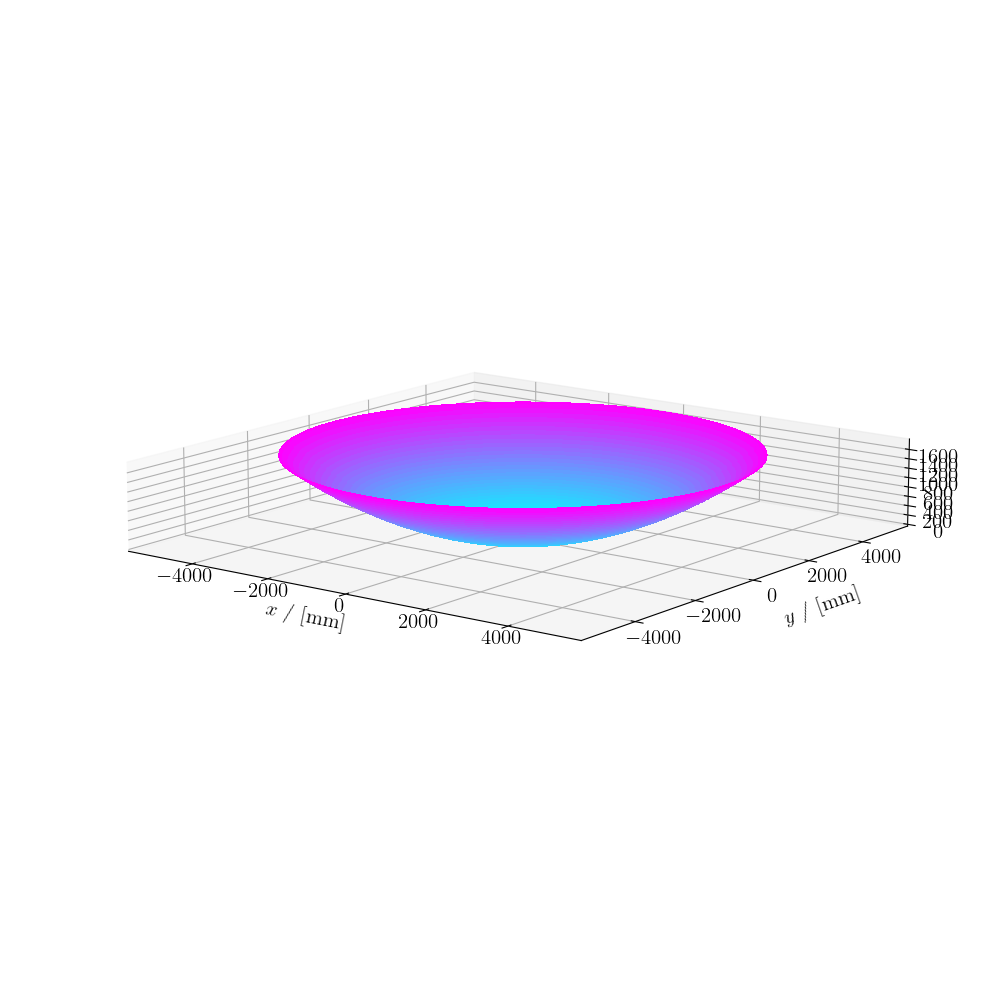

In [2]:
parabola = {
            "name"      : "primary",
            "pmode"     : "focus",
            "gmode"     : "uv",
            "flip"      : False,
            "vertex"    : np.zeros(3),
            "focus_1"   : np.array([0, 0, 3.5e3]),
            "lims_u"    : np.array([0, 5e3]),
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([801, 801])
            }

s.addParabola(parabola)
s.plotSystem()


After that we plot the system using the s.plotSystem function. This method plots all elements in the current system.
Now that we have an optical element, we can proceed and perform a ray-trace through the system. 

We start by defining an initial frame of rays above the paraboloid we just made.

2023-04-06 18:17:31 - INFO - Added tubular frame start to system. 
dict_keys(['start'])


<IPython.core.display.Javascript object>


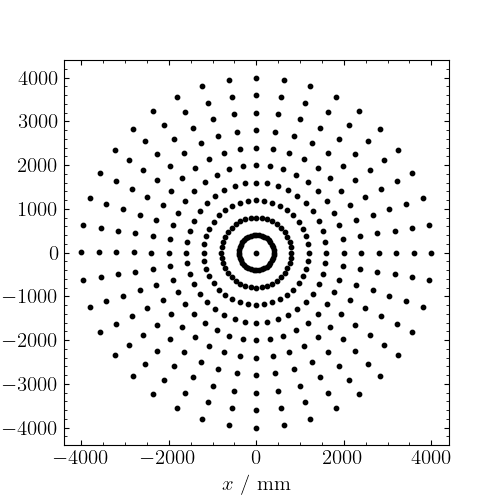

2023-04-06 18:17:31 - INFO - Translated frame start by ('0.000e+00', '0.000e+00', '3.500e+03') millimeters. 


In [3]:
RTpar = {
        "name"      : "start",
        "nRays"     : 10,
        "nRing"     : 10,
        "angx0"     : 0,
        "angy0"     : 0,
        "x0"        : 4000,
        "y0"        : 4000
        }

s.createTubeFrame(RTpar)
print(s.frames.keys())
s.plotRTframe("start")
s.translateGrids("start", np.array([0, 0, 3.5e3]), obj="frame")

We made a tubular ray-trace frame consisting of an annular distribution of rings containing rays. This type of frame can be used to simulate point sources, collimated beams and anything in between. However, for quantitative analysis this model is not the best. In a later tutorial, we will investigate another model which is more appropriate for this end. 

Adding frames to the system is also done by specifying a dictionary. The first field is the name of the frame. This name is the way whe can interact with this frame through the system object. The next field is the number of rays per annular ring. Note that the total amount of rays in a ring will be a multiple of four of the specified 'nRays' in the field. The next field, 'nRing', specifies the total amount of annular rings. The next two fields, 'angx0' and 'angy0', specify the opening angles along the x and y axes. The opening angle will vary smoothly over an annulus. The last two fields, 'x0' and 'y0', specify the radii of the outer annulus in the frame.

As mentioned, the name of the frame will be the main way of interacting with the frame object, which is stored in the system object. This is immediately demonstrated after adding the frame to the system. we translate the frame to the focal plane of the paraboloid. 

To inspect a frame, we can call the s.plotRTframe method, passing the name of the frame as an argument.

We then propagate the initialised frame to the paraboloid:

2023-04-06 18:17:35 - INFO - *** Starting RT propagation *** 
2023-04-06 18:17:35 - INFO - Hardware: running 12 CPU threads. 
2023-04-06 18:17:35 - INFO - ... Calculating ... 
2023-04-06 18:17:35 - INFO - *** Finished: 0.009 seconds *** 


<IPython.core.display.Javascript object>


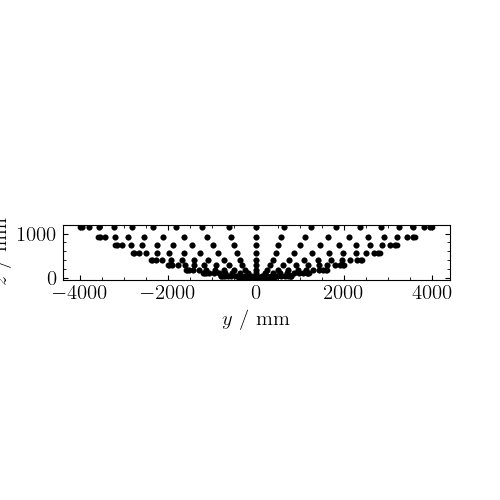

In [4]:
start_pri_RT = {
            "fr_in"     : "start",
            "t_name"    : "primary",
            "fr_out"    : "fr_pri",
            "device"    : "CPU",
            "tol"       : 1e-6
            }

s.runRayTracer(start_pri_RT)
s.plotRTframe("fr_pri", project='yz')


The ray-trace is done, again, using a dictionary. This time, we specify the initial frame using the 'fr_init' field. Then, we specify the target surface using 't_name'. We specify the name of the output frame using 'fr_out'. We can also specify the device on which the calculation is performed. We use 'CPU' in this case. Note that if 'GPU' is selected, CUDA should be installed. If 'GPU' is specified and no CUDA is installed, PyPO defaults to the CPU. The last field is the tolerance 'tol' for the ray-tracer. This value defaults to 1e-3, but for illustration we put it a bit higher.

After running, we plot the frame on the paraboloid. We select project='yz' which plots the frame with y as abscissa and z as ordinate. This confirms that the frame is indeed defined on the paraboloid.

Now, we will propagate the rays to the focus of the paraboloid. We do this by first finding the focus. Luckily, the method in system that does this, automatically generates a surface in the focus and the corresponding frame, which means we can immediately plot the frame.

2023-04-06 18:17:40 - INFO - Focus: ('1.423e-14', '1.258e-14', '3.500e+03'), RMS: 6.312e-06 


<IPython.core.display.Javascript object>


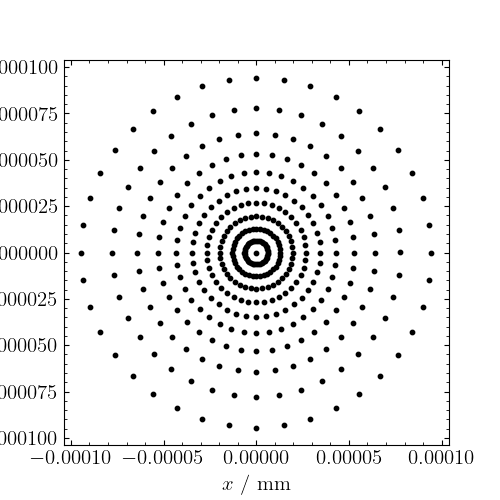

<IPython.core.display.Javascript object>


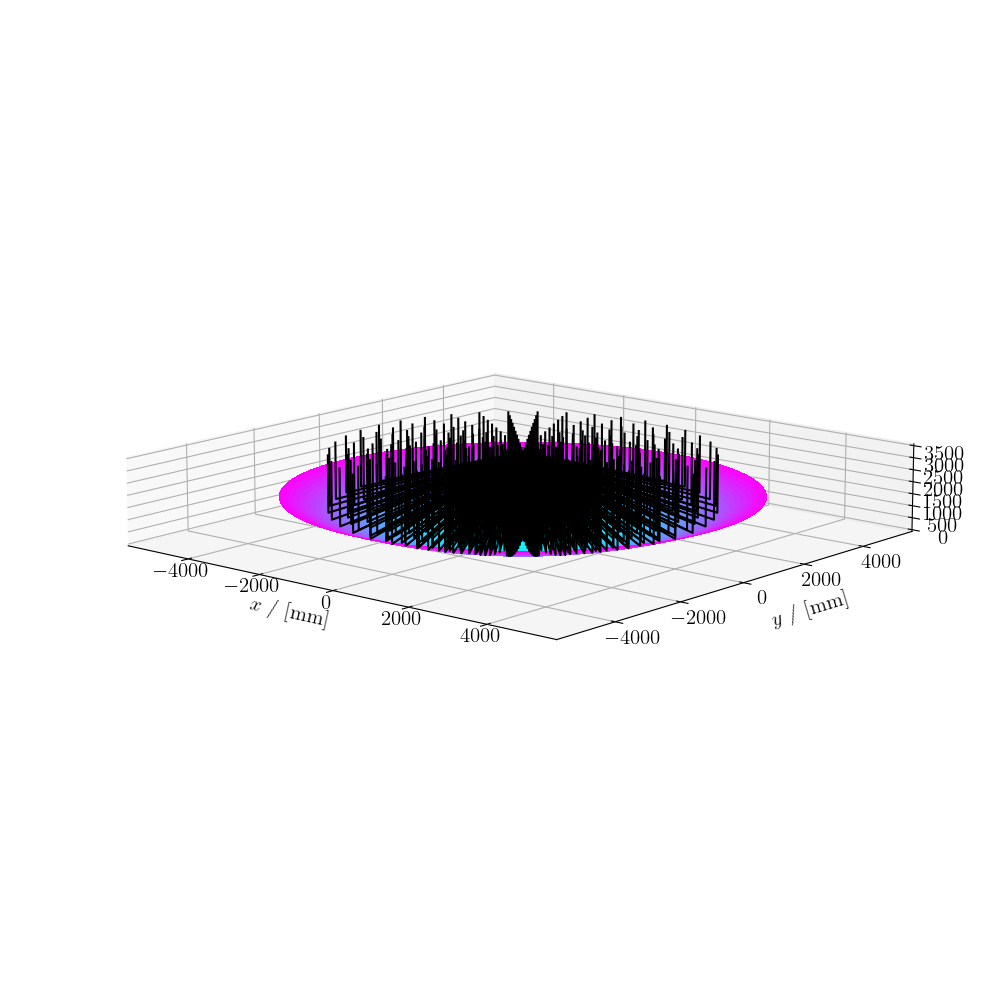

In [5]:
s.findRTfocus("fr_pri")

s.plotRTframe("focus_fr_pri")
s.plotSystem(RTframes=["start", "fr_pri", "focus_fr_pri"])

The s.findRTfocus method takes as argument the name of the frame of which the focus needs to be found. At the end of the call, it places the focus frame in the system. The name of this new frame will be the name of the frame passed as argument, prepended by 'focus_'. Also, the plane corresponding to the focus is stored in the system. The name of the plane is the name of the input frame, prepended by 'focal_plane_'.

We again run the plotSystem method, but this time we pass an extra argument named RTframes. This is a list of frame names in system that we would like to plot. The plotSystem method then connects the rays in each frame and draws lines between them. This makes it easier to visualise the path of the rays between frames.